<a href="https://colab.research.google.com/github/josh-ashkinaze/reddit_relationships_analysis/blob/master/Reddit_Relationships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: This ipynb file was made in Google Collab; 
open in Google Collab instead of jupyter for best results / no syntax errors!*

# Outline of Analysis 

I have two main research questions. 

1.   What are latent topics that people post about?
2.   What are the topics associated with different relationship partners?

To answer these questions, I'll proceed like this: 
1. Explore data
 * Inspecting data types
 * Descriptive statistics
 * Adding features
2. Define methods for text mining 
 * Preprocessing data, 
    * Cleaning text
    * Tokenizing
 * Building NMF model 
 * Displaying NMF model
3. Analyze data 
 * Topics for entire subreddit
 * Topic by relationship partner 
 * Hypothesis tests 





# Explore DataFrame

Install packages.



In [0]:
# Install dependencies not loaded in Collab
!pip install nltk
!pip install textblob


# Utilities / Data Manipulation
import re
import string 
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
from google.colab import files

# NLP Libraries 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Graphing libraries 
import seaborn as sns 
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

nltk.download("stopwords")
nltk.download('punkt')
clear_output()

## Read in dataframe

In [0]:
# Upload file 
url = 'https://raw.githubusercontent.com/josh-ashkinaze/reddit_relationships_analysis/master/relationships_data.csv'
df = pd.read_csv(url, index_col=0)

## Inspect dataframe

Let's look at the head, tail, length, and columns. 
Let's make sure there aren't too many missing values. 

In [14]:
# Examine structure
display("Head", df.head(5))
display("Tail", df.tail(5))
display("Length", len(df))

# Take a look at columns 
display(df.dtypes, "\n")

# Check for null values in columns
null_columns = df.columns[df.isnull().any()]
empty = df.loc[df['self_txt'].isnull()]
display("Post with no self text: \n \n", str(empty['title']))

# Since it's just one post, and we want to use self_text, let's drop it. 
df.dropna(subset=['self_txt'], inplace=True)



'Head'

,author,flair,post_id,score,self_txt,timestamp,title,upvote_ratio
0,itsme2213,Updates,a72pyo,14488,Original post is here: [https://www.reddit.com...,1.545073e+09,[UPDATE] I'm [28F] unsure if it's time to draw...,0.98
1,whenlifegivesyoushit,Updates,3hw1jh,11005,[Original Post](https://www.reddit.com/r/relat...,1.440188e+09,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,0.95
2,AggressiveImpact7,Updates,abxvly,10996,link to original post: [https://www.reddit.com...,1.546464e+09,update to: Husband and I are having our longes...,0.98
3,LadyGrey90,Non-Romantic,beku6e,10712,[Original post](https://www.reddit.com/r/relat...,1.555590e+09,[UPDATE] My (28F) colleague (30F) didn't invit...,0.97
4,AbandonedTraveler,Updates,a1ta8x,10228,So many through comments and PMs requested an ...,1.543591e+09,[UPDATE] I [29F] am traveling overseas to meet...,0.98


'Tail'

,author,flair,post_id,score,self_txt,timestamp,title,upvote_ratio
884,BAP0223,Infidelity,4j6jn9,1656,"My boyfriend, John, and I have been together f...",1.463149e+09,I [25/f] saw an email from an online dating si...,0.95
885,tronpalmer,Updates,3duc7p,1656,[First Post](https://www.reddit.com/r/relation...,1.437320e+09,[UPDATE] My [25 M] childhood best friend [25 M...,0.92
886,IPAsmakemydickhard,Updates,3va8sk,1661,I have never done an update before so forgive ...,1.449154e+09,"UPDATE: Me [27F] a recovering addict, dating [...",0.96
887,testyrearend,Updates,8rcfoh,1652,Original post [here.](https://www.reddit.com/r...,1.529081e+09,UPDATE: I [F26] am feeling lonely in a relatio...,0.97
888,tawaysleptonthecouch,Updates,445bn7,1651,Original post: https://www.reddit.com/r/relati...,1.454594e+09,My [22F] boyfriend [29M] of 19 months is furio...,0.96


'Length'

889

author           object
flair            object
post_id          object
score             int64
self_txt         object
timestamp       float64
title            object
upvote_ratio    float64
dtype: object

'\n'

'Post with no self text: \n \n'

"387    Me [28F] with my [29F] co-worker, she doesn't ...\nName: title, dtype: object"

## Add features

Let's tag the season of a post and the subject. 

In [16]:
# Now we want to add some features. 
# In particular, we want to add:
# 1. Y, M, D, and hour
# 2. Subject of posts 


def parse_date(df):
  """
  Parses a UNIX timestamp in a dataframe - 
  Creates year, month, day, and hour as features
  """
  df['date'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)
  df['year'] = pd.DatetimeIndex(df['date']).year  
  df['month'] = pd.DatetimeIndex(df['date']).month
  df['day'] = pd.DatetimeIndex(df['date']).dayofweek + 1 # make weekday start at 1 (Week starts on Monday)
  df['hour'] = pd.DatetimeIndex(df['date']).hour + 1 #make hour start at 1
  return df 


# Parse date and tag seasons
df = parse_date(df)

# Assign partners based on title 
df.loc[df['title'].str.contains('girlfriend|gf'), 'subj'] = 'GF'
df.loc[df['title'].str.contains('boyfriend|bf'), 'subj'] = 'BF'
df.loc[df['title'].str.contains('husband'), 'subj'] = 'Husband'
df.loc[df['title'].str.contains('wife'), 'subj'] = 'Wife'

# Count up each subject
subj_df = pd.value_counts(df.subj).to_frame().reset_index()
display(subj_df)

# Let's make sure this all worked out 
display(df.head())



,index,subj
0,BF,130
1,Husband,105
2,GF,103
3,Wife,74


,author,flair,post_id,score,self_txt,timestamp,title,upvote_ratio,date,year,month,day,hour,season,subj
0,itsme2213,Updates,a72pyo,14488,Original post is here: [https://www.reddit.com...,1.545073e+09,[UPDATE] I'm [28F] unsure if it's time to draw...,0.98,2018-12-17 19:00:12+00:00,2018,12,1,20,Winter,BF
1,whenlifegivesyoushit,Updates,3hw1jh,11005,[Original Post](https://www.reddit.com/r/relat...,1.440188e+09,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,0.95,2015-08-21 20:07:02+00:00,2015,8,5,21,Summer,Husband
2,AggressiveImpact7,Updates,abxvly,10996,link to original post: [https://www.reddit.com...,1.546464e+09,update to: Husband and I are having our longes...,0.98,2019-01-02 21:20:35+00:00,2019,1,3,22,Winter,NaN
3,LadyGrey90,Non-Romantic,beku6e,10712,[Original post](https://www.reddit.com/r/relat...,1.555590e+09,[UPDATE] My (28F) colleague (30F) didn't invit...,0.97,2019-04-18 12:16:30+00:00,2019,4,4,13,Spring,NaN
4,AbandonedTraveler,Updates,a1ta8x,10228,So many through comments and PMs requested an ...,1.543591e+09,[UPDATE] I [29F] am traveling overseas to meet...,0.98,2018-11-30 15:17:03+00:00,2018,11,5,16,Autumn,BF


## Descriptive statistics and visualizations

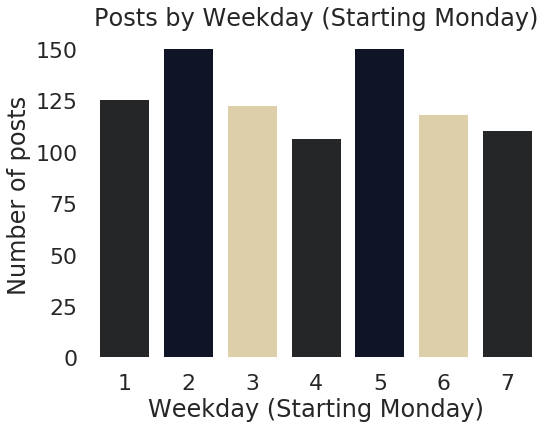

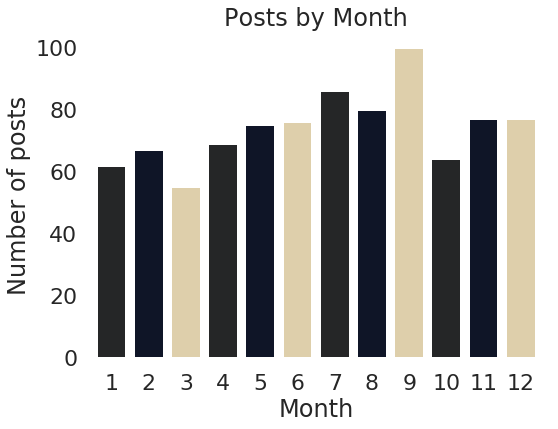

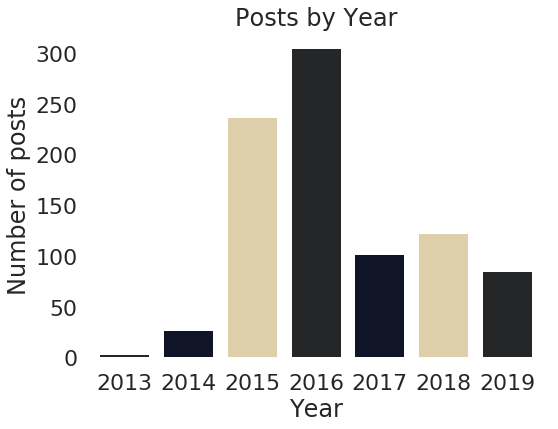

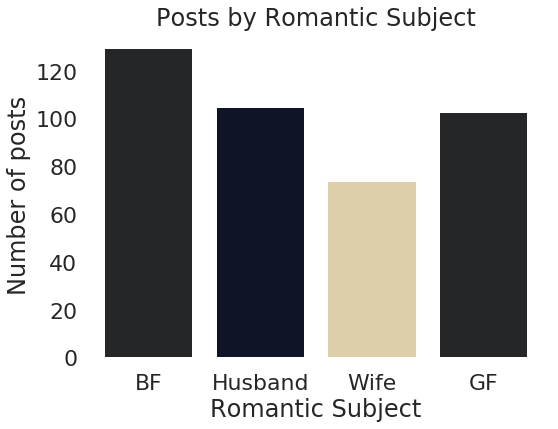

count    888.000000
mean       0.949505
std        0.027541
min        0.740000
25%        0.940000
50%        0.960000
75%        0.970000
max        0.990000
Name: upvote_ratio, dtype: float64


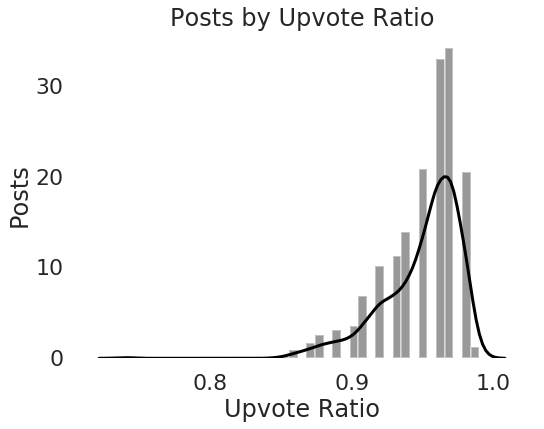

count      888.000000
mean      2814.560811
std       1406.610766
min       1651.000000
25%       1925.000000
50%       2333.500000
75%       3178.750000
max      14488.000000
Name: score, dtype: float64


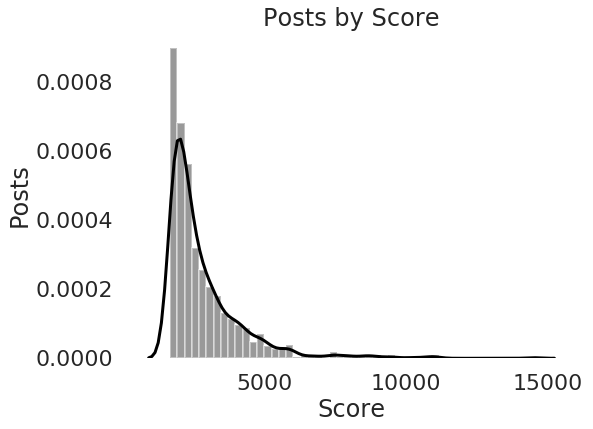

In [39]:
import seaborn as sns 
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')


my_colors = ["#252627", "#0B132B", "#E6D3A3"]
def config_graph():
  """
  Set context to poster
  """
  sns.set(context='poster', style="white")
  
def countplot(df, var, label):
  
  # Style settings and filename
  config_graph()
  plt.figure(figsize=(8,6))
  filename = "{}{}.png".format("count", label)

  # Make plot 
  plot = sns.countplot(x=var, data=df, palette=my_colors)
  
  # Despine 
  sns.despine(left=True, bottom=True, top=True, right=True)
  
  #  Label
  plt.xlabel(label)
  plt.ylabel("Number of posts")
  plt.title("Posts by {}".format(label))
#   plt.savefig(filename, dpi=500, bbox_inches="tight", transparent=True)
#   files.download(filename)
  plt.show()
  plt.close("all")
  
def distplot(df, var, label): 
  
  # Style settings and filename
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  filename = "{}{}.png".format("dist", label)
  
  # Make plot
  plot = sns.distplot(df[var], color="Black")
  
  # Despine 
  sns.despine(left=True, bottom=True, top=True, right=True)
  
  # Label 
  plt.xlabel(label)
  plt.ylabel("Posts")
  plt.title("Posts by {}".format(label))
#   plt.savefig(filename, dpi=500, bbox_inches="tight", transparent=True)
#   files.download(filename)
  plt.show()
  plt.close("all")

# Make countplots 
countplot_labels = {
          'day': 'Weekday (Starting Monday)', 
          'month':'Month', 
          'year':'Year',
          'subj': 'Romantic Subject'
}
for var in countplot_labels:
  countplot(df, var, countplot_labels[var])
 
# Make distplots
distplot_labels = {
          'upvote_ratio': 'Upvote Ratio', 
          'score':'Score'
}
for var in distplot_labels:
  print(df[var].describe())
  distplot(df, var, distplot_labels[var])


  


# Define functions for text mining 

##  Cleaning text

In [0]:
# Returns a tokenized form of a string 

def preprocess(docs, settings):
  """ 
  Clean and tokenize text document
  """
  clean_docs = [clean_text(i, settings) for i in docs]
  clean_docs = [tokenize(i, settings) for i in clean_docs]

  return clean_docs

def tokenize(text, settings):
  """ 
  Tokenizes text -- returning the tokens as a string 
  """
  nltk_tokenizer = nltk.WordPunctTokenizer().tokenize
  tokens = nltk_tokenizer(text)  
  result =  [i for i in tokens if len(i)>settings['min_len']]
  result = " ".join(result)
  
  return result

def clean_text(text, settings): 
  """ 
  Cleans text -- 
  
  Removes case, removes punctuation,
  removes stopwords, and removes numbers (if specified. 
  """
  new_text = make_lowercase(text)
  new_text = remove_punct(new_text)
  if settings['keep_numbers'] is False: 
    new_text = remove_numbers(new_text)
  new_text = remove_stopwords(new_text, settings)
#   new_text = correct_spelling(new_text)
  return new_text

def correct_spelling(text):
  new_text = str(TextBlob(text).correct())
  return new_text

def make_lowercase(text):
  new_text = text.lower()
  return new_text

def remove_numbers(text):
  new_text = ''.join([i for i in text if not i.isdigit()])
  return new_text

def remove_stopwords(text, settings):
  stop_words = set(stopwords.words("english")).union(settings['custom_stopwords'])
  new_text = ' '.join([i for i in text.split() if not i in stop_words])
  return new_text

def remove_punct(text: str) -> str:
    for p in string.punctuation:
        text = text.replace(p, '')
    return text



## Creating topics

In [0]:

def print_topic_dist(W, labels=None, title=None):
  """
  Creates graph of NMF topic distribution  
  """
  
  # Note: Assigning a topic to a post is a little handwavy. 
  # Every post is some linear combination of topics, so 
  # I take the argmax of the weights. In other words, 
  # If post X's largest weight corresponds to topic A, 
  # then I assign topic A to post X. 
  
  topics = pd.DataFrame(W).idxmax(axis=1, skipna=True).tolist()
  dfW = pd.DataFrame(topics, columns=['topic'])
  dfW.sort_values("topic", inplace=True)
  
  # Topic percentages
  topic_percentages = dfW['topic'].value_counts(normalize=True)
  print(topic_percentages)
    
  # Plot settings 
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  filename = "NMF"
  
  # Make plot with labels 
  a = sns.countplot(y='topic', data=dfW, palette= my_colors)
  if labels:
    a.set_yticklabels(labels)
  a.set(xlabel="Number of Posts")
  a.set(ylabel="Topic")
  if title:
    plt.title(title)

  sns.despine(left=True, bottom=True, top=True, right=True)
#   plt.savefig("topics.png", dpi=500, bbox_inches="tight", transparent=True)
#   files.download("topics.png")
  plt.show()
  plt.close()
  return df

  
def display_topics(H, W, feature_names, df, no_top_words, no_top_documents):
  """ 
  Provides info on topic model by printing words 
  associated with topic and representative documents. 
  """
  for topic_idx, topic in enumerate(H):
      print ("Topic {}: ".format(topic_idx)  + ",".join(
          [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
      top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
      for idx in top_doc_indices:
          print (df['title'].tolist()[idx])
      print()

            
# Build a topic analysis model 
def make_topics(df, clean_docs, settings):
  """ 
  Build a topic analysis model - 
  
  Using a TF-IDF vectorizer and an NMF model
  for dimensionality reduction. 
  """
  no_topics = settings['n_topics'] # hypothesized latent topics 
  no_top_words = settings['n_top_words'] # number of sample words per topic 
  no_top_documents = settings['n_top_docs'] # number of docs to print per topic 
  ngram = settings['ngram']
  max_df = settings['max_df']
  
  # Fit a TFIDF vectorizer 
  tfidf_vectorizer = TfidfVectorizer(
                                     max_df=max_df,
                                     min_df = 5,
                                     stop_words='english', 
                                     ngram_range = (ngram[0], ngram[1])
  )
  
  tfidf = tfidf_vectorizer.fit_transform(clean_docs)
  tfidf_feature_names = tfidf_vectorizer.get_feature_names()

  # Run NMF
  nmf_model = NMF(n_components=no_topics,
                  random_state=1, 
                  alpha=0.000001, 
                  init='nndsvd').fit(tfidf)
  
  nmf_W = nmf_model.transform(tfidf)
  nmf_H = nmf_model.components_
  
 
  # Display topics 
  display_topics(nmf_H, nmf_W, tfidf_feature_names, df, no_top_words, no_top_documents)
  return nmf_W, nmf_H




# Topic Mining Analysis 

## Q1: What are the latent topics in the data?

In [42]:

clean_settings = {
         "min_len": 2,
         "keep_numbers": False,
          "custom_stopwords":{
                             'told',
                             'post',
                             "wants",
                             "want",
                             "update"
  }
}
 

topic_settings = {"n_topics": 5, 
                  "n_top_words": 7, 
                  "max_df": 0.8,
                  "n_top_docs": 7, 
                  "ngram": [1,1]            
}
  
# Get a list of titles  
my_df = df.dropna(subset=['title'])
documents = my_df['title'].tolist()
clean_docs = preprocess(documents, clean_settings)
print("Cleaned. \n")

# Build topic model x
W, H = make_topics(df, clean_docs, topic_settings)




Cleaned. 

Topic 0: dont,know,sister,family,brother,deal,daughter
UPDATE: I [23/F] don't know whether my SO [24/M] of two year's appearance-related "preferences" cross the line.
[Update]Friend [37/F] is about to be turned-down for a promotion she has dreamed of for years. I [36/F] know it's coming and don't know how to support her or what to do.
(update!) My girlfriend [29F] introduced me to her son [13M] and I don't know if I want to parent him
UPDATE Me [30F] with my BF [30M] duration, I want to send him sexy pictures as a surprise but I don't know if I should.
Friend [37/F] is about to be turned-down for a promotion she has dreamed of for years. I [36/F] know it's coming and don't know how to support her or what to do.
UPDATE: My (28M) pregnant wife (26F) has gonorrhea and I don't know what to do
[Update] "Me [27 F] with my BF [28 M] of seven years. I don't know what I did wrong..."

Topic 1: boyfriend,year,feel,months,friends,years,break
[Update] Boyfriend [25M] and his sister-in-l

It looks like the topics are:

1. Indecision: These posts are about not knowing what to do or how to appraise a situation. 
2. Boyfriend concerns
3. " All these years?" Crazy stuff happening with partners you've know for awhile 
4. Husband complaints 
5. Friends either becoming more or less than friends 

4    0.363739
2    0.199324
3    0.192568
0    0.123874
1    0.120495
Name: topic, dtype: float64


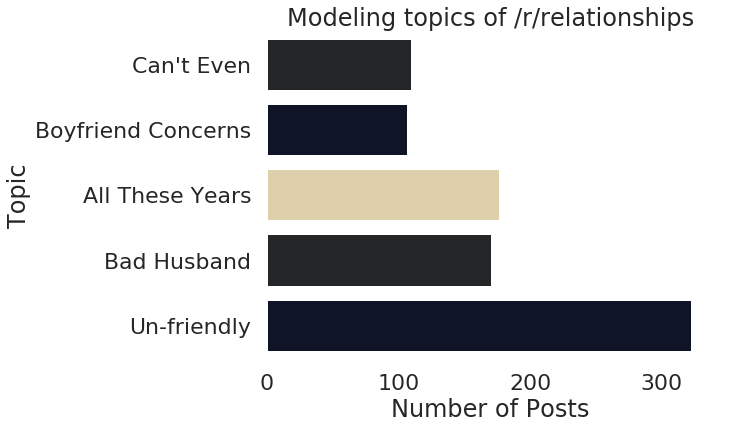

In [29]:

labels = ["Can't Even", "Boyfriend Concerns", "All These Years", "Bad Husband", "Un-friendly"]
topic_df = print_topic_dist(W, labels, "Modeling topics of /r/relationships")


 Now we will set up some functions to print the top terms in a corpus using a TF-IDF vectorizer.  

In [0]:

def graph_terms(clean_docs, n_words, ngram):
  """
  Graphs results from a TF-IDF vectorizer 
  """
  plt.figure(figsize=(8,11))
  sns.set_context("poster")
  sns.set_style='White'
  vect = create_vectorizer(clean_docs, n_words, ngram)
  df = rank_terms(clean_docs, vect)
  print(df)
  sns.barplot(data=df, y='term', x='rank')
  sns.despine(left=True, right=True, bottom=True, top=True)
  plt.title("Importance")
  plt.ylabel("Term")
  plt.xlabel("Frequency in r/relationships posts \ndivided by frequency in English language")
  plt.show()
  
def rank_terms(clean_docs, vect):
  """
  Returns the results of a TF-IDF vectorizer in a dataframe
  """
  tfidf_result = vect.fit_transform(clean_docs)
  sums = tfidf_result.sum(axis=0)
  terms = vect.get_feature_names()
  data = []
  for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))
  df = pd.DataFrame(data, columns=['term','rank'])
  df.sort_values("rank", ascending=False, inplace=True)
  return df

# This will be vectorizer we use to rank terms 
def create_vectorizer(clean_docs, n_words, ngram):
  """
  Crate a TF-IDF vectorizer
  """
  vect = TfidfVectorizer(max_df=0.99,  max_features=n_words, stop_words='english',ngram_range=(ngram, ngram))
  return vect



## Q2: What are the topics for each relationship partner?

Now we explore topics by relationship partner. 

Let's switch to looking at selftext as the feature. The issue we'll run into with looking at just post title is that as we slice and dice the dataset, the corpus will be very small. But because we're using selftext there is more noise. So we need to add a bunch of stopwords. 

In [0]:
  
# So many stopwords...
clean_settings = {
         "min_len": 4,
         "keep_numbers": False,
          "custom_stopwords":{
                             'told',
                             'dont',
                             'got',
                             "family", 
                             "update",
                             "doesent", 
                             "didnt", 
                             "wasnt",
                             'post',"posts"
                             "want", "wants"
                             "update", 
                             "updates", 
                             "really", 
                             "going", "think"
                             "relationship", 
                             "girlfriend", 
                             "things",
                             "boyfriend", 
                             "husband", 
                             "wife", 
                             "wanted", 
                             "think",
                             "year", 
                             "years"
  }
}
 

So, let's take some of the above functions and use them to understand what people say about different relationship partners. 

Since we don't know how many topics to produce for each subject, let's try n in  {3, 4, 5} for each subject. After looping through subjects and testing what topic number is best, we'll store the optimal number of topics for each subject

******************** BF ******************** 
 

Testing 3 Topics 

Topic 0: friends,relationship,months,broke,original,started,dating,thought,advice,right
UPDATE: Every year, my boyfriend (21M) and I (22F) go on a ?break? because he doesn?t know what he wants
I [24F] found out my best friend [24F] had sex with my boyfriend [26F]; I'm upset and can't believe it
Update "Me [27 F] heartbroken after my [26 M] boyfriend of 6 years backs out of planned proposal"
My [24F] sister [25F] and her bf [25M] are upset because my fiance [27M] proposed to me and have started shaming us on social media
Update: My [25f] boyfriend [26m] of 10 months is best friends with his ex [20s?f]. She refuses to meet me and it's getting weird

Topic 1: phone,house,leave,called,stuff,saying,friend,tinder,wouldnt,email
[UPDATE] Me (21F) with my boyfriend (24M) he wants me to cut off contact with his brother because he defended me in an argument.
My (F22) boyfriend (M31) of three years won?t stop using dating apps. I 

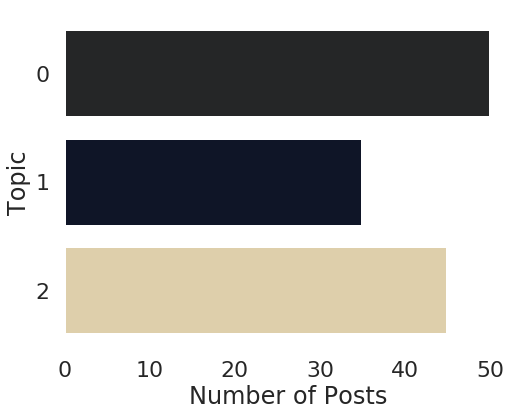

Testing 4 Topics 

Topic 0: months,relationship,broke,original,dating,needed,started,thank,ended,thought
UPDATE: Every year, my boyfriend (21M) and I (22F) go on a ?break? because he doesn?t know what he wants
Update "Me [27 F] heartbroken after my [26 M] boyfriend of 6 years backs out of planned proposal"
Update from original post of my bf (24M) not wanting me (22F) to take antidepressants.
[UPDATE]Me [21 F] engaged after 2 months of knowing each other and dating with my boyfriend [20 M] duration, short-description
[UPDATE] My [28F] boyfriend [27M] of three years refused to pull over while he was driving, pissed himself, and then kinda blamed me for it.

Topic 1: friends,friend,close,girls,asked,doesnt,apartment,relationship,started,weekend
Update: I [27f] dumped my boyfriend [27m] for using cocaine. Now his friends hate me.
My [24F] sister [25F] and her bf [25M] are upset because my fiance [27M] proposed to me and have started shaming us on social media
I [23F] am so sick of people i

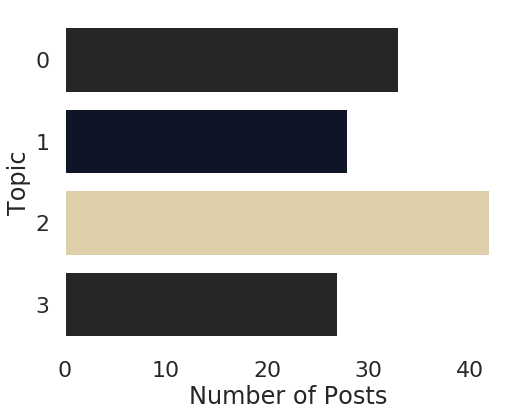

Testing 5 Topics 

Topic 0: friends,friend,girls,relationship,close,asked,weekend,talking,dinner,mutual
Update: I [27f] dumped my boyfriend [27m] for using cocaine. Now his friends hate me.
I [23F] am so sick of people in my social circle [20s M-F] implying that something is going on with me and my boyfriend's [25M] best friend [24M]
My [24F] sister [25F] and her bf [25M] are upset because my fiance [27M] proposed to me and have started shaming us on social media
[UPDATE] My [25F] boyfriend's [27M] best friend [27M] cheated on his girlfriend of 5 years numerous times. Today I found out that my boyfriend knew about it & actually helped his friend cheat.
My boyfriend [23M] pretended to be single in front of other girls while I [21F] was standing right there. Is this grounds to break up immediately or should I give him a chance to explain himself?

Topic 1: phone,house,leave,stuff,email,tinder,wouldnt,speak,called,saying
[Update] Guy [M30's] I used to work with got a bunch of nudes off my

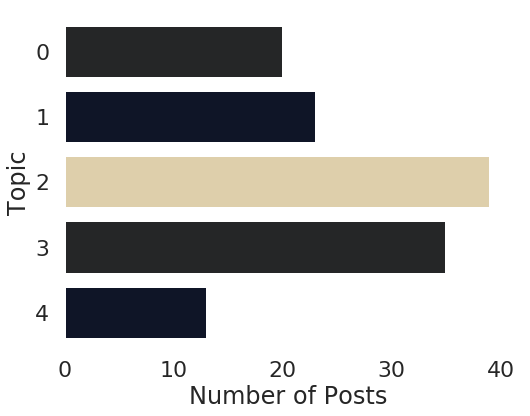

******************** HUSBAND ******************** 
 

Testing 3 Topics 

Topic 0: better,thank,right,child,needed,little,thing,advice,actually,therapy
[UPDATE] My [36F] husband [39M] of 13 years is against having our cat euthanized; implies I want to 'murder' the cat for being an 'inconvenience'
[Update] My (31F) husband's (32M) mother (60sF) has Alzheimers. He moved her in with us and is not actively looking for a nursing home. My house is a mess and I am at my wits end
UPDATE I[27F] feel like I am getting pregnant because it was expensive and my husband[31M] wants children.I'm not sure I want a baby.
[Update] Me [33F] and my husband [34M], together for 10 years ? He is uncomfortable with how often I touch him
Update: How do I [26F] tell my husband [31M] I'm addicted to drugs?

Topic 1: sister,sisters,house,parents,daughter,brother,money,moved,college,later
My sister [32] and her husband [30] are getting evicted from their apartment, and my mom [65] and dad [67] thinks that I [40M] sh

KeyboardInterrupt: ignored

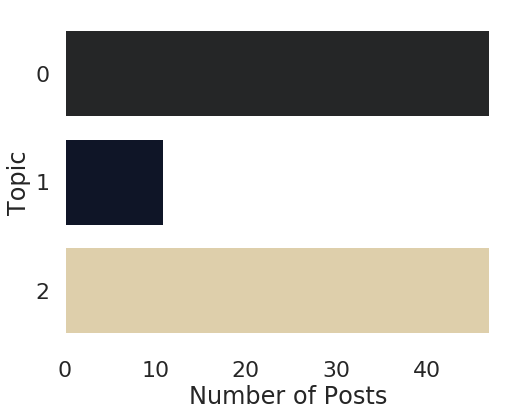

In [32]:
# Loop through subjects, and test a different number of topics. 


n_topics = [3, 4, 5]
topic_settings['n_top_words'] = 10
topic_settings['n_top_docs'] = 5
topic_settings['ngram'] = [1,1]

for subj in ("BF", "Husband", "Wife", "GF"):
  print( "*"*20, subj.upper(), "*"*20, "\n \n")
  mydf = df.loc[(df['subj'] == subj)]
  docs = mydf['self_txt'].tolist()
  clean_docs = preprocess(docs, clean_settings)
  for n in n_topics:
    print("Testing {} Topics for {} \n".format(n, subj))
    topic_settings['n_topics'] = n
    W, H = make_topics(mydf, clean_docs, topic_settings)
    print_topic_dist(W)
  

                        


******************** BF ******************** 
 

Topic 0: months,relationship,broke,original,dating,needed,started,thank,ended,thought
UPDATE: Every year, my boyfriend (21M) and I (22F) go on a ?break? because he doesn?t know what he wants
Update "Me [27 F] heartbroken after my [26 M] boyfriend of 6 years backs out of planned proposal"
Update from original post of my bf (24M) not wanting me (22F) to take antidepressants.
[UPDATE]Me [21 F] engaged after 2 months of knowing each other and dating with my boyfriend [20 M] duration, short-description
[UPDATE] My [28F] boyfriend [27M] of three years refused to pull over while he was driving, pissed himself, and then kinda blamed me for it.

Topic 1: friends,friend,close,girls,asked,doesnt,apartment,relationship,started,weekend
Update: I [27f] dumped my boyfriend [27m] for using cocaine. Now his friends hate me.
My [24F] sister [25F] and her bf [25M] are upset because my fiance [27M] proposed to me and have started shaming us on social media


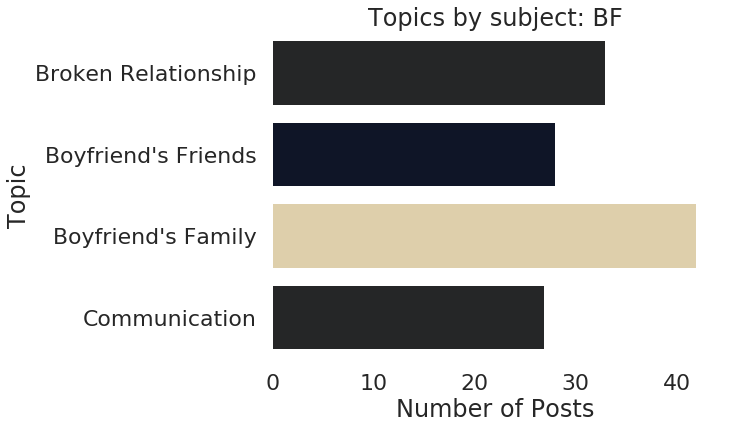

             term      rank
9   thanks advice  6.718161
4     right thing  6.494092
8  thank comments  6.153093
0   close friends  6.058347
7    thank advice  5.937006
3  mutual friends  5.609648
1    havent heard  5.349754
6     story short  5.201228
2  months started  4.909041
5  started dating  3.607792


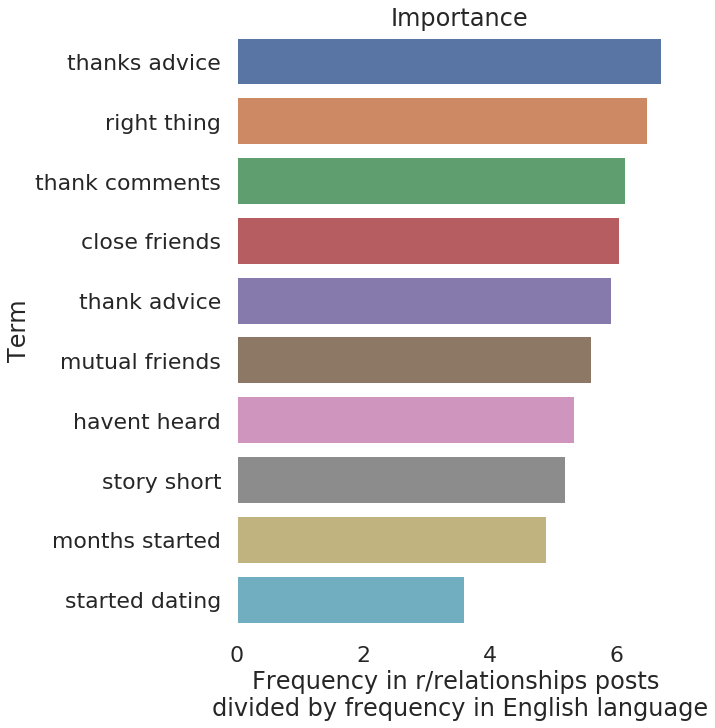

******************** HUSBAND ******************** 
 

Topic 0: better,thank,right,needed,little,advice,thing,actually,helped,issues
[UPDATE] My [36F] husband [39M] of 13 years is against having our cat euthanized; implies I want to 'murder' the cat for being an 'inconvenience'
[Update] My (31F) husband's (32M) mother (60sF) has Alzheimers. He moved her in with us and is not actively looking for a nursing home. My house is a mess and I am at my wits end
Update: How do I [26F] tell my husband [31M] I'm addicted to drugs?
[UPDATE] My [23F] husband's [28M] father [60'sM] died and now my husband is an absolute monster.
[Update] Me [33F] and my husband [34M], together for 10 years ? He is uncomfortable with how often I touch him

Topic 1: sister,sisters,house,parents,daughter,brother,money,later,moved,apartment
My sister [32] and her husband [30] are getting evicted from their apartment, and my mom [65] and dad [67] thinks that I [40M] should let them live in my beach house for free
[UPDATE]

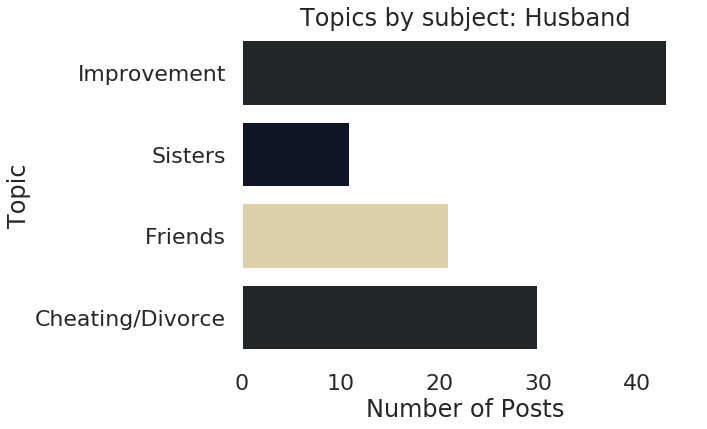

               term      rank
3       hours later  5.719918
8       story short  5.694176
1   getting divorce  5.055829
7    started crying  5.036392
6      social media  4.782848
9      thank advice  4.375196
0     friends house  4.288871
2  getting divorced  4.270975
5       right thing  2.741373
4  husbands friends  2.440874


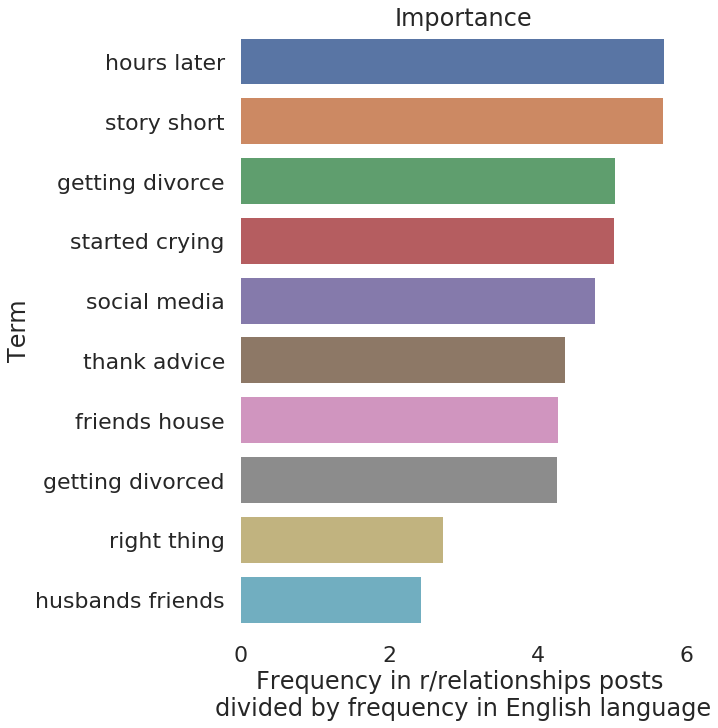

******************** WIFE ******************** 
 

Topic 0: asked,right,talked,friends,thought,friend,pretty,advice,happened,pictures
Me [30M] and my wife [36F] of 5 years, have been dealing with my obsessed ex-gf [28F] for years, but it has now started to affect my wife negatively
Update - My injured wife[27-f] of 3 years just told me[25-m] to start sleeping with other women. [NSFW]
I (31M) found out my wife (30F) has been getting a coworker (29F) to spy on me at work.
[UPDATE] My [24F] mum [54F] has not seen my dad [52M] since their messy divorce, nor met the OW/his new wife [42F] [...] they are all attending my graduation where they will also meet my bf's [23M] parents for the first time. (!!!)
[Update] My [28M] friends/co-workers [20s M/F] are mocking my wife [22F] and our arranged marriage, not sure how to address or deal with this?

Topic 1: daughter,daughters,needs,college,clothes,sister,money,times,called,month
My (M/47) wife (F/39) has kicked our daughter (F/19) out of my hous

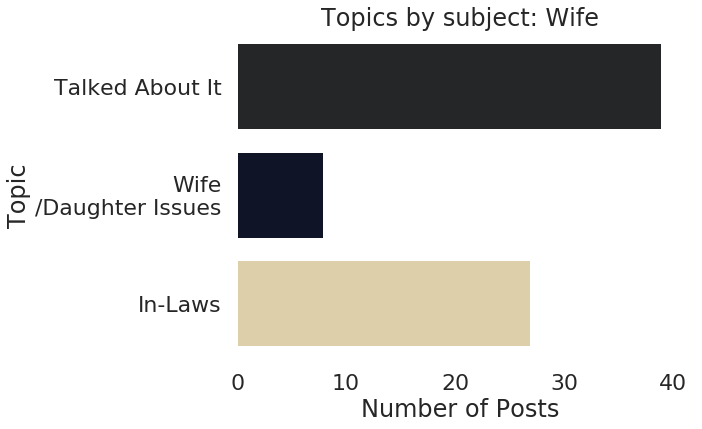

              term      rank
6      story short  4.349391
7     thank advice  4.303600
3   started crying  4.280037
5  started talking  3.739878
8     wifes friend  3.299937
4   started dating  3.193488
2     sister house  2.953959
0  original thread  2.912457
9   wives supposed  1.000000
1  picture parents  0.965200


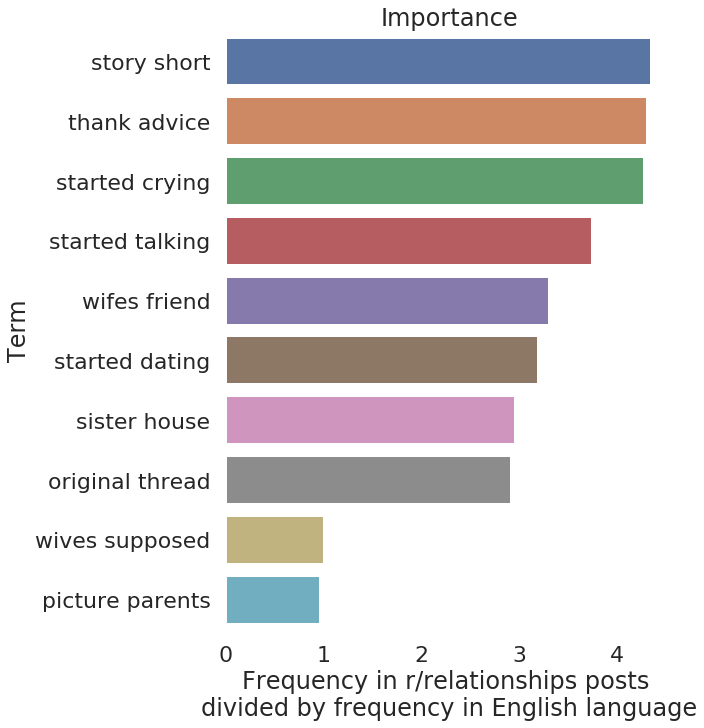

******************** GF ******************** 
 

Topic 0: friends,friend,cheating,couple,asked,night,message,months,phone,started
[UPDATE] I [22M] suspect something between my girlfriend [22F] and my friend [21M]. We all live together. Am I imagining things?
[UPDATE 2] I [22M] suspect something between my girlfriend [22F] and my friend [21M]. We all live together. Am I imagining things?
UPDATE: My [28F] girlfriend and I [38F] got into a fight. She posted a long "apology" letter on a social media website and it really pisses me off.
(UPDATE) I (20/M) am worried that my girlfriend (23/F) is codependent on me, because she has been relying on me entirely for emotional support and fulfillment.
My [32m] girlfriends [29f] cousin [27f] has manipulated my girlfriend to the point that I am thinking about walking away after 7 years together. Am I over reacting?

Topic 1: sister,photo,house,sisters,saying,scared,apparently,night,college,right
My sister [20F] described to me a really weird and thre

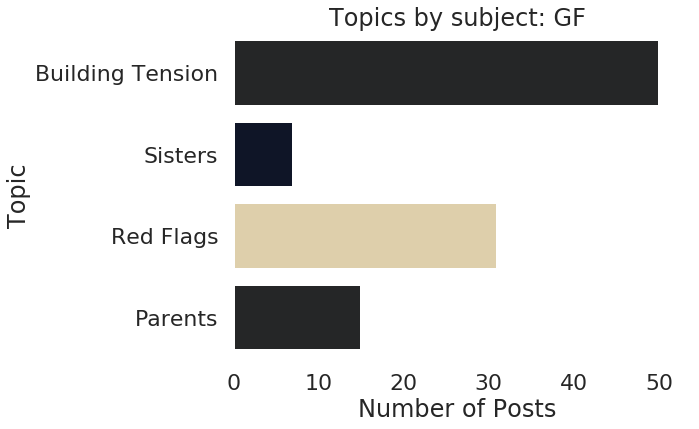

             term      rank
8  started crying  6.044227
7    social media  5.333110
0   couple months  4.000000
1    couple times  3.970915
9  started dating  3.345958
6   mental health  2.911105
3   friends house  2.902663
5     later night  1.965919
4     girls night  1.898475
2    derek brooke  1.789354


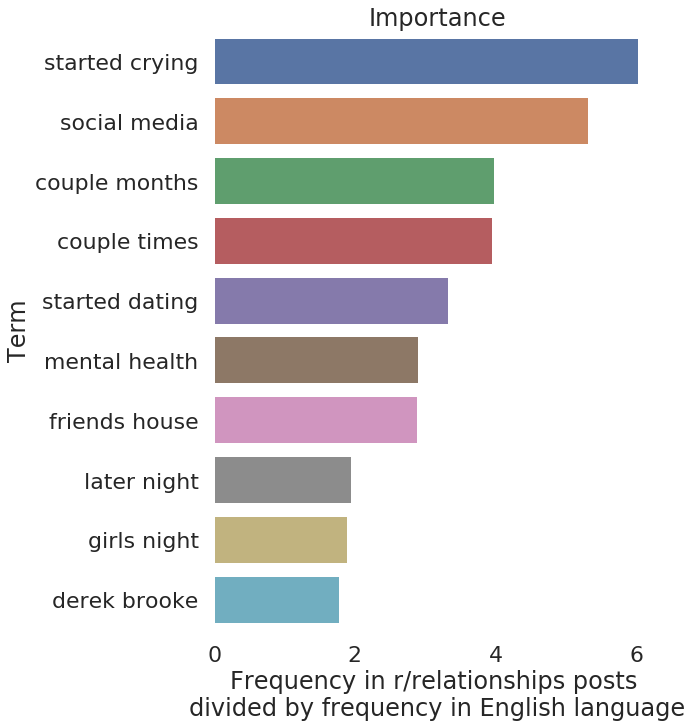

In [37]:
# Now we'll put the optimal topic data in a dictionary, and loop through 
# again, but this time with the optimal number of topics and their labels. 
subj_settings = {}
subj_settings['BF'] = (4, ["Broken Relationship", "Boyfriend's Friends", "Boyfriend's Family", "Communication"])
subj_settings['Husband'] = (4, ["Improvement", "Sisters", "Friends", "Cheating/Divorce"])
subj_settings['Wife'] = (3, ["Talked About It", "Wife\n/Daughter Issues", "In-Laws"])
subj_settings['GF'] = (4, ["Building Tension", "Sisters", "Red Flags", "Parents"])

for subj in ("BF", "Husband", "Wife", "GF"):
  
  ntopics = subj_settings[subj][0]
  labels =  subj_settings[subj][1]
  
  print( "*"*20, subj.upper(), "*"*20, "\n \n")
  
  mydf = df.loc[(df['subj'] == subj)]
  docs = mydf['self_txt'].tolist()
  clean_docs = preprocess(docs, clean_settings)
  topic_settings['n_topics'] = ntopics
  W, H = make_topics(mydf, clean_docs, topic_settings)
  print_topic_dist(W, labels, "Topics by subject: {}".format(subj))
  graph_terms(clean_docs, 10, 2)

# Hypothesis Tests

I have two hypotheses based on the topic modeling. Let's test them. 

First: GF posts mention sisters more than BF posts.

Second: Wife posts mention daughters more than husband posts. 


## H1: I hypothesize that posts about girlfriends mention sisters more than posts about boyfriends. 


In [0]:

# One-Sided --> Reject HO if (two-sided) p-value/2 < 0.05 AND
# sign as hypothesized

# H0: gf_count = bf_count
# Posts about wives mention daughters as much as posts about husbands. 

# HA: gf_count > bf_count
# Posts about wives mention daughters MORE THAN posts about wives.


features = ['self_txt', 'title']
for feature in features:
  bf = df.loc[df['subj'].isin(["BF"])]
  bf_count = bf[str(feature)].str.count("sister")

  gf = df.loc[df['subj'].isin(["GF"])]
  gf_count = gf[str(feature)].str.count("sister")
  
  t_stat = ttest_ind(gf_count, bf_count, equal_var=False)[0]
  p_val = (ttest_ind(gf_count, bf_count, equal_var=False)[1])/2 
  
  print("Testing Hpy 1 for {}\n t_stat = {}, p_val = {} \n".format(feature, t_stat, p_val))



Testing Hpy 1 for self_txt
 t_stat = 1.7400274182704474, p_val = 0.042306984376455824 

Testing Hpy 1 for title
 t_stat = 0.13147856624199733, p_val = 0.44776550780311863 



## H2: I hypothesize that posts about girlfriends mention sisters more than posts about boyfriends. 

In [0]:


# One-Sided --> Reject HO if (two-sided) p-value/2 < 0.05 AND
# sign as hypothesized

# H0: wife_count = hus_count 
# Posts about wives mention daughters as much as posts about husbands. 

# HA: wife_count > hus_count
# Posts about wives mention daughters MORE THAN posts about wives. 

for feature in features:
  wife = df.loc[df['subj'].isin(["Wife"])]
  wife_count = wife[str(feature)].str.count("daughter")

  hus = df.loc[df['subj'].isin(["Husband"])]
  hus_count = hus[str(feature)].str.count("daughter")
  
  t_stat = ttest_ind(wife_count, hus_count, equal_var=False)[0]
  p_val = (ttest_ind(wife_count, hus_count, equal_var=False)[1])/2 

  print("Testing Hpy 2 for {}\n t_stat = {}, p_val = {} \n".format(feature, t_stat, p_val))


Testing Hpy 2 for self_txt
 t_stat = 1.5288888433182273, p_val = 0.06495700593972586 

Testing Hpy 2 for title
 t_stat = 1.8199420396582195, p_val = 0.03604373852596851 

